# Predicting sale price of houses

The aim of this project is to build a machine learning model to predict sale price of houses, based on multiple explanatory variables describing aspects of these houses.
The dataset used for this project is available on [Kaggle.com](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)


# House price prediction : Feature engineering

This notebook is the second step of our project which steps features :
- 1\.  Data analysis
- **2\.  Feature engineering**
- 3\.  Feature selection
- 4\.  Model building

In the following, we will engineer / pre-process the variables of the House Price Dataset.

In [32]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.simplefilter(action='ignore')

In [2]:
data = pd.read_csv('./House_Price/houseprice.csv')
print(data.shape)

data.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## train and test set

In [3]:
#RANDOM_SEED = 0

X_train, X_test, y_train, y_test = train_test_split(data, data['SalePrice'], test_size=0.1, random_state= 0)

X_train.shape, X_test.shape

((1314, 81), (146, 81))

## handling missing values

### categorical

We will start by the case of categorical variables. We will replace missing values with the string "missing".

In [4]:
list_var_cat_na = [col for col in X_train if X_train[col].isnull().sum() > 0 and X_train[col].dtype == 'O']

In [5]:
X_train[list_var_cat_na].isnull().mean()

Alley           0.938356
MasVnrType      0.004566
BsmtQual        0.024353
BsmtCond        0.024353
BsmtExposure    0.025114
BsmtFinType1    0.024353
BsmtFinType2    0.025114
Electrical      0.000761
FireplaceQu     0.472603
GarageType      0.056317
GarageFinish    0.056317
GarageQual      0.056317
GarageCond      0.056317
PoolQC          0.995434
Fence           0.814307
MiscFeature     0.961187
dtype: float64

In [6]:
X_train[list_var_cat_na] = X_train[list_var_cat_na].fillna("Missing")
X_test[list_var_cat_na] = X_test[list_var_cat_na].fillna("Missing")

### numerical variables

For numerical variables we will create columns with booleans (0,1) indicating if there is a missing value for a variable, and fill the missing values in the variables with the mode.

In [7]:
list_var_num_na = [col for col in X_train.columns if X_train[col].isnull().sum() > 0 and  X_train[col].dtype != 'O']

X_train[list_var_num_na].isnull().mean()

LotFrontage    0.177321
MasVnrArea     0.004566
GarageYrBlt    0.056317
dtype: float64

In [8]:
list_var_num_na

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

In [9]:
for var in list_var_num_na:
    mod_val = X_train[var].mode()[0]
    
    X_train[var + "_na"] = np.where(X_train[var].isnull(), 1, 0)
    X_test[var + "_na"] = np.where(X_test[var].isnull(), 1, 0)
    
    X_train[var] = X_train[var].fillna(mod_val)
    X_test[var] = X_test[var].fillna(mod_val)
    

In [10]:
X_train[['LotFrontage_na', 'MasVnrArea_na', 'GarageYrBlt_na']].head()

,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
930,0,0,0
656,0,0,0
45,0,0,0
1348,1,0,0
55,0,0,0


## handling temporal variables

As we saw in the previous notebook, there are 4 temporal variables which refers to the year where the garage was built, when the house whas remodeled etc.

We will capture the years elapsed between those variables and the year in which the houses were sold

In [11]:
def elapsed_year(df, var):
    # differene between YrSold - var
    df[var] = df["YrSold"] - df[var]
    return df

In [12]:
for col in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    X_train = elapsed_year(X_train, col)
    X_test = elapsed_year(X_test, col)

## handling numerical variables transformation

We saw in our data analysis that some numerical variables where not normally distributed.
We will apply a log-transformation to the ones that are strictly positive, in order to fit a linear model.

In [13]:
for col in ['LotFrontage', 'LotArea', '1stFlrSF', 'GrLivArea', 'SalePrice']:
    X_train[col] = np.log(X_train[col])
    X_test[col] = np.log(X_test[col])


In [14]:
[var for var in ['LotFrontage', 'LotArea', '1stFlrSF',
                 'GrLivArea', 'SalePrice'] if X_test[var].isnull().sum() > 0]

[]

## Categorical variables

### removing rare labels

In [18]:
list_cat_vars = [var for var in X_train.columns if X_train[var].dtype == 'O']

def find_frequent_labels(df, var, tolerance):
    df = df.copy()
    
    tmp = df.groupby(var)['SalePrice'].count() / len(df)
    
    return tmp[tmp > tolerance].index


In [21]:
for var in list_cat_vars:
    
    frequent_label = find_frequent_labels(X_train, var, 0.01)
    
    X_train[var] = np.where(X_train[var].isin(frequent_label), X_train[var], 'rare')
    X_test[var] = np.where(X_test[var].isin(frequent_label), X_test[var], 'rare')

### encoding categorical variables

In [26]:
def replace_cat(train, test, var, target):
    ordered_labels = train.groupby([var])[target].mean().sort_values().index
    
    ordinal_label = {k: i for i, k in enumerate(ordered_labels, 0)}
    
    train[var] = train[var].map(ordinal_label)
    test[var] = test[var].map(ordinal_label)

    
for var in list_cat_vars:
    replace_cat(X_train, X_test, var, "SalePrice")


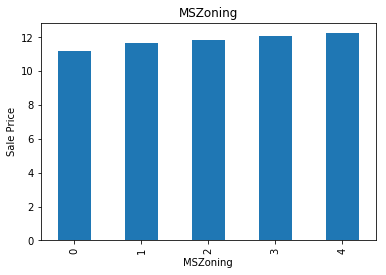

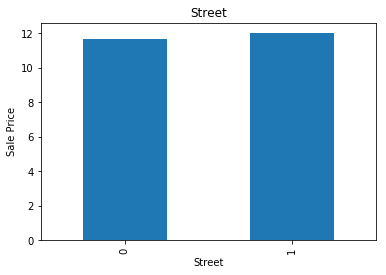

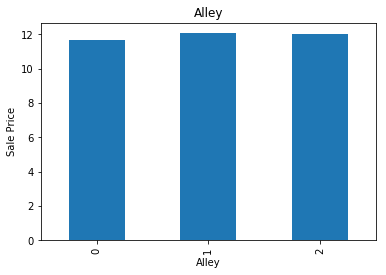

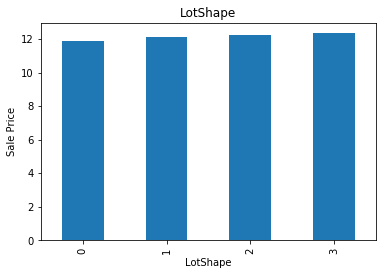

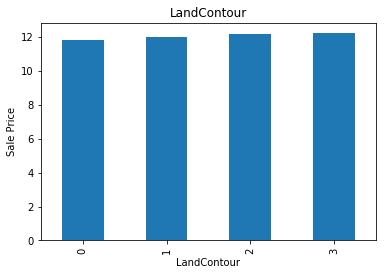

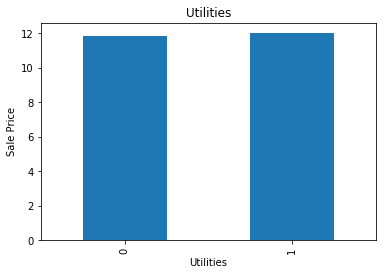

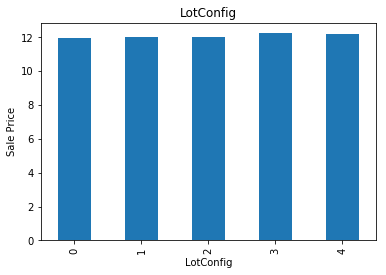

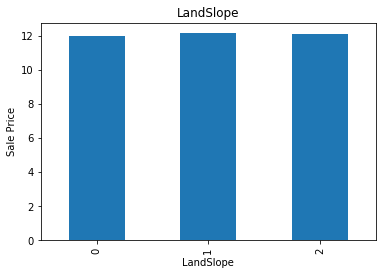

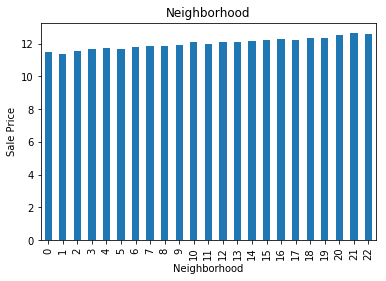

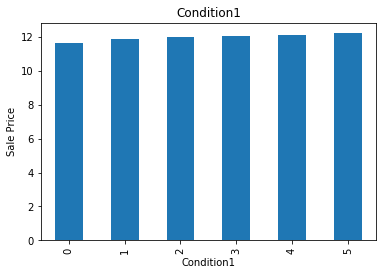

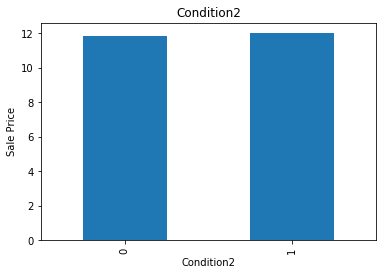

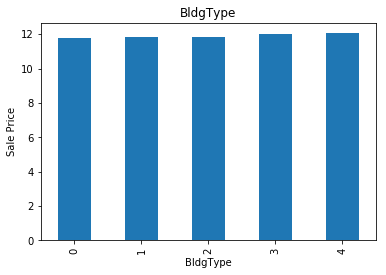

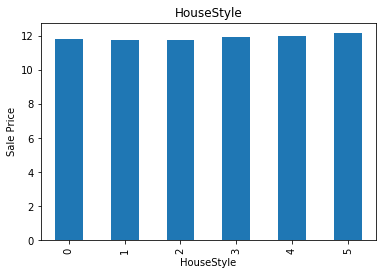

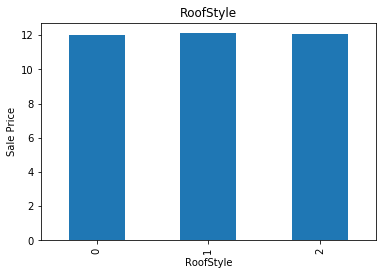

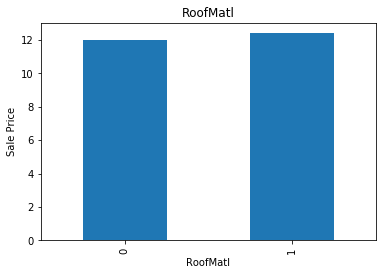

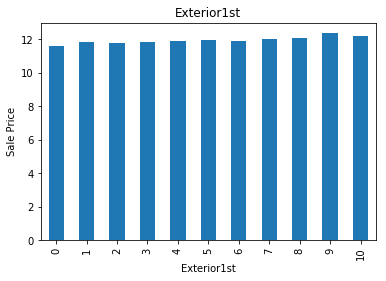

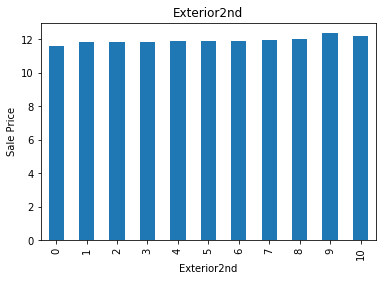

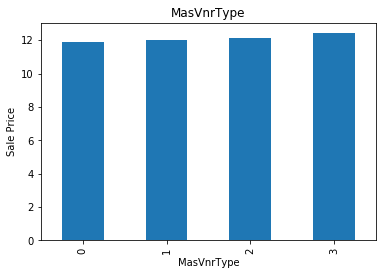

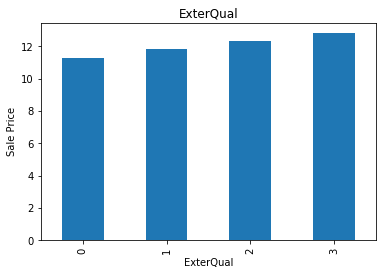

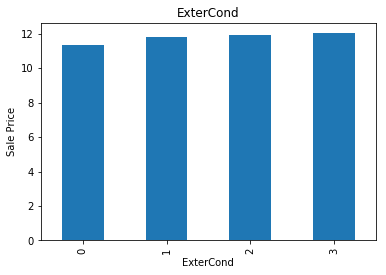

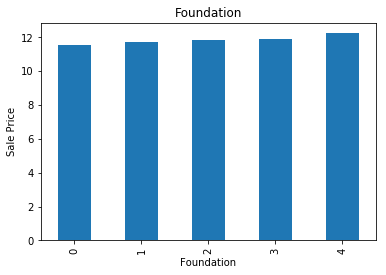

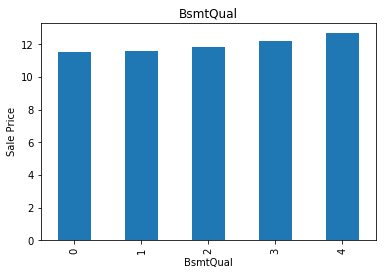

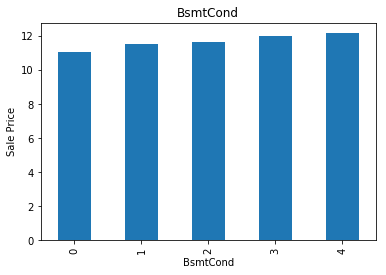

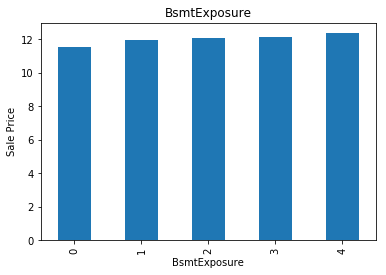

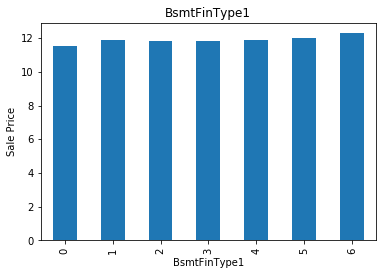

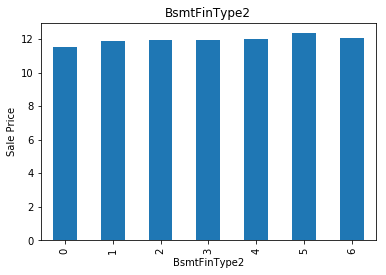

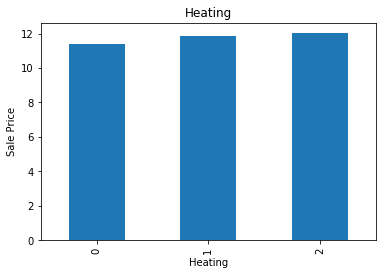

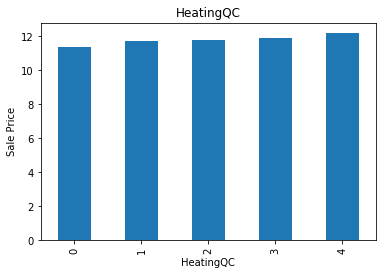

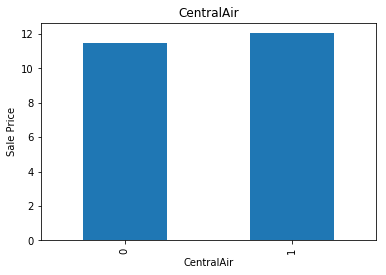

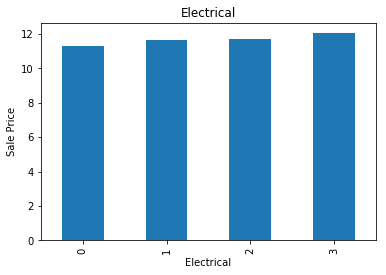

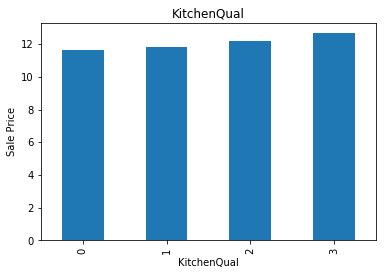

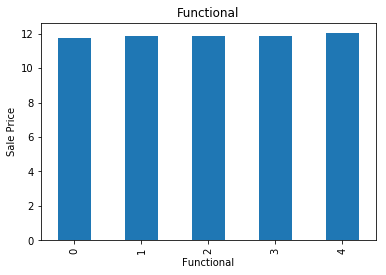

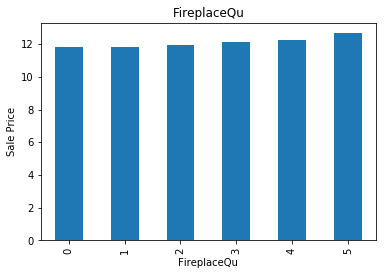

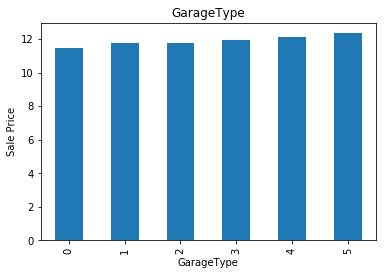

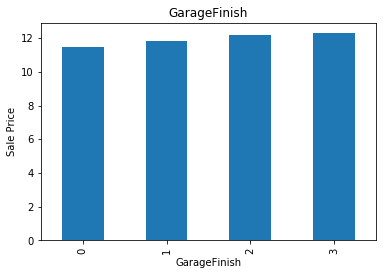

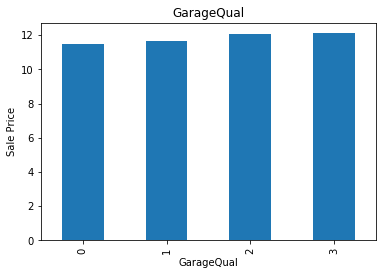

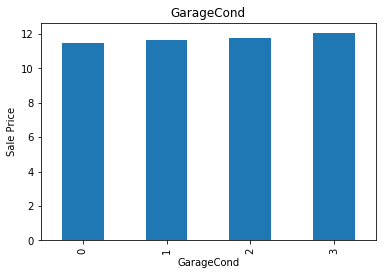

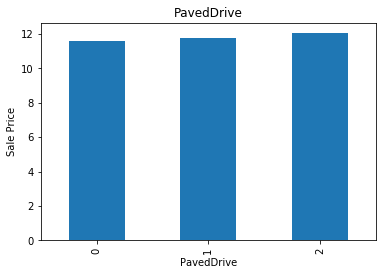

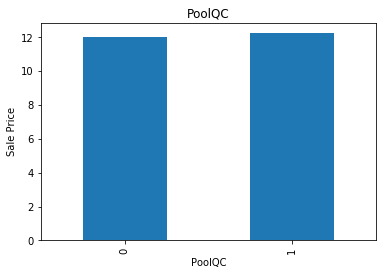

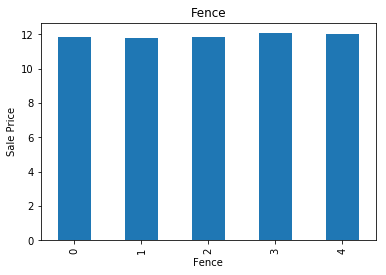

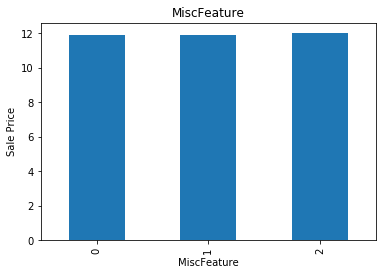

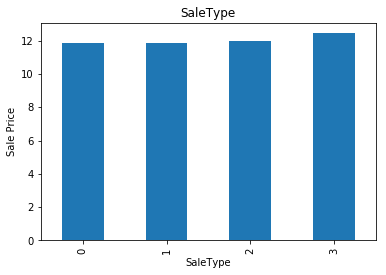

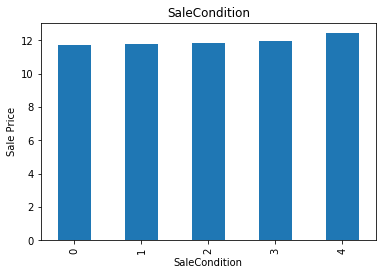

In [29]:
def analyse_var(df, var):
    df = df.copy()
    df.groupby(var)["SalePrice"].median().plot.bar()
    
    plt.title(var)
    plt.ylabel("Sale Price")
    plt.show()
    
for var in list_cat_vars:
    analyse_var(X_train, var)

The monotonic relationship is particularly clear for the variables MSZoning. Now,the higher is the integer representing the category, the higher is the mean of the house price.

## Feature scaling

To use a linear model, we need to scale or normalize the values of the variables.

In [30]:
train_cols = [col for col in X_train.columns if col not in ["Id", "SalePrice"]]

len(train_cols)

82

In [33]:
scaler = MinMaxScaler()

scaler.fit(X_train[train_cols]) 


X_train[train_cols] = scaler.transform(X_train[train_cols])

X_test[train_cols] = scaler.transform(X_test[train_cols])

In [34]:
X_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
930,931,0.000000,0.75,0.461171,0.377048,1.0,1.0,0.333333,1.000000,1.0,...,1.0,0.0,0.545455,0.75,0.666667,0.75,12.211060,0.0,0.0,0.0
656,657,0.000000,0.75,0.456066,0.399443,1.0,1.0,0.333333,0.333333,1.0,...,1.0,0.0,0.636364,0.50,0.666667,0.75,11.887931,0.0,0.0,0.0
45,46,0.588235,0.75,0.394699,0.347082,1.0,1.0,0.000000,0.333333,1.0,...,1.0,0.0,0.090909,1.00,0.666667,0.75,12.675764,0.0,0.0,0.0
1348,1349,0.000000,0.75,0.388581,0.493677,1.0,1.0,0.666667,0.666667,1.0,...,1.0,0.0,0.636364,0.25,0.666667,0.75,12.278393,1.0,0.0,0.0
55,56,0.000000,0.75,0.577658,0.402702,1.0,1.0,0.333333,0.333333,1.0,...,1.0,0.0,0.545455,0.50,0.666667,0.75,12.103486,0.0,0.0,0.0


In [35]:
X_train.to_csv('xtrain.csv', index=False)
X_test.to_csv('xtest.csv', index=False)